In [118]:
import os
import os.path as osp
import random
import sys
from collections import Counter
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
import torch_geometric.transforms as T
from dataset import GraphDataset
from models import *
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss, Linear, LogSoftmax, ReLU
from torch_geometric import utils
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    BatchNorm,
    DMoNPooling,
    GATConv,
    GCNConv,
    GraphConv,
    MessagePassing,
    Sequential,
    TopKPooling,
    global_mean_pool,
)
from torch_geometric.nn.conv.gcn_conv import gcn_norm

In [119]:
def analyze_dataset(dataset, min_num_nodes=None, max_num_nodes=None):
    num_graphs = len(dataset)
    num_classes = dataset.num_classes if hasattr(dataset, "num_classes") else None
    num_node_features = (
        dataset.num_node_features if hasattr(dataset, "num_node_features") else None
    )
    labels = [data.y.item() for data in dataset]
    num_nodes = [data.num_nodes for data in dataset]
    class_distribution = Counter(labels)
    avg_num_nodes = sum(num_nodes) / len(num_nodes)
    min_nodes = min(num_nodes)
    max_nodes = max(num_nodes)

    small_threshold = 20
    large_threshold = 60

    small_graphs = []
    medium_graphs = []
    large_graphs = []

    classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }

    small_classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }

    medium_classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }

    large_classes = {
        "class_0": [],
        "class_1": [],
        "class_2": [],
        "class_3": [],
        "class_4": [],
        "class_5": [],
    }

    for i in dataset:
        c = i.y
        class_name = "class_" + str(c.item())
        if min_num_nodes and max_num_nodes:
            if min_num_nodes <= i.num_nodes <= max_num_nodes:
                classes[class_name].append(i)
        else:
            classes[class_name].append(i)

    print(f"Total number of graphs: {num_graphs}")
    if num_classes:
        print(f"Number of classes: {num_classes}")
    if num_node_features:
        print(f"Number of node features: {num_node_features}")
    print(f"Average number of nodes per graph: {int(avg_num_nodes)}")
    print(f"Max number of nodes in a graph: {max_nodes}")
    print(f"Min number of nodes in a graph: {min_nodes}")

    print("Class distribution:")
    for cls, count in class_distribution.items():
        print(f" - Class {cls}: {count} graphs ({100 * count / num_graphs:.2f}%)")

    plt.figure(figsize=(10, 6))
    plt.hist(num_nodes, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Distribution of Number of Nodes in {dataset.name} Dataset")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    for graph in dataset:
        c = graph.y
        class_name = "class_" + str(c.item())
        if graph.num_nodes < small_threshold:
            small_graphs.append(graph)
            small_classes[class_name].append(graph)
        elif graph.num_nodes > large_threshold:
            large_graphs.append(graph)
            large_classes[class_name].append(graph)
        else:
            medium_graphs.append(graph)
            medium_classes[class_name].append(graph)

    print(f"Small graphs: {len(small_graphs)}")
    print(f"Medium graphs: {len(medium_graphs)}")
    print(f"Large graphs: {len(large_graphs)}")

    return (
        small_graphs,
        medium_graphs,
        large_graphs,
        classes,
        small_classes,
        medium_classes,
        large_classes,
    )

Total number of graphs: 360
Number of classes: 4
Number of node features: 4
Average number of nodes per graph: 18
Max number of nodes in a graph: 19
Min number of nodes in a graph: 17
Class distribution:
 - Class 1: 90 graphs (25.00%)
 - Class 0: 90 graphs (25.00%)
 - Class 2: 90 graphs (25.00%)
 - Class 3: 90 graphs (25.00%)


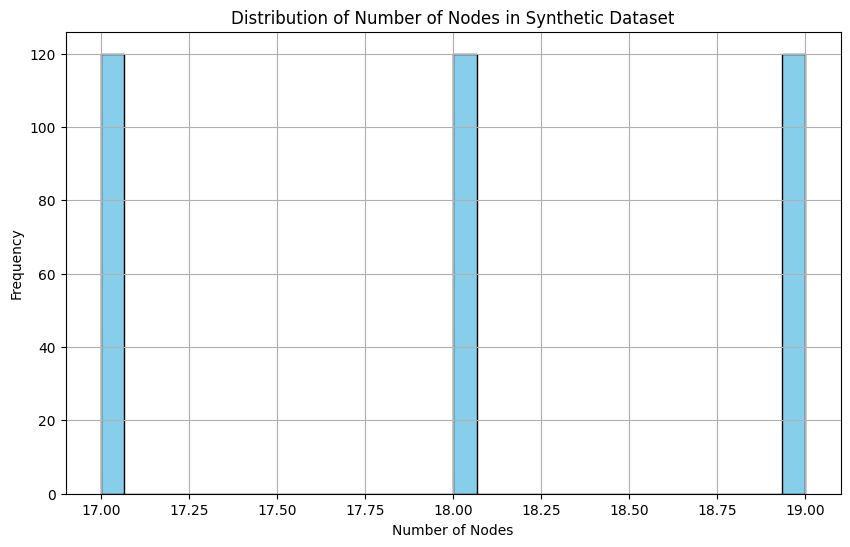

Small graphs: 360
Medium graphs: 0
Large graphs: 0


In [120]:
dataset = GraphDataset(torch.load("../data/cycle_line_star_complete_1_15.pt"))

(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [121]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [122]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
    return correct / total

In [123]:
import torch

from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from itertools import product


# Define NewArgs class
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs


# Define hyperparameter grid
dim_values = [32]
num_layers_values = [5, 6, 7]
lr_values = [0.001]
batch_size_values = [32, 64]

# Load your dataset
dataset = GraphDataset(torch.load("../data/cycle_line_star_complete_1.pt"))

# Split the dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize loss function
criterion = CrossEntropyLoss()


def train_and_evaluate(args, train_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    model = AdjustedGATModel(args).to(args.device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    num_epochs = 100
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, args.device)
        scheduler.step()

    accuracy = test(model, test_loader, args.device)
    return accuracy


# Perform grid search
best_accuracy = 0
best_params = None

# for dim, num_layers, lr, batch_size in product(
#     dim_values, num_layers_values, lr_values, batch_size_values
# ):
#     args = NewArgs(dim, num_layers, 0.2, lr, batch_size, 400)
#     accuracy = train_and_evaluate(args, train_dataset)
#     print(
#         f"Params: dim={dim}, num_layers={num_layers}, lr={lr}, batch_size={batch_size}, Accuracy: {accuracy}"
#     )
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_params = (dim, num_layers, lr, batch_size)

# print(
#     f"Best Params: dim={best_params[0]}, num_layers={best_params[1]}, lr={best_params[2]}, batch_size={best_params[3]}, Best Accuracy: {best_accuracy}"
# )

In [124]:
import networkx as nx
from torch_geometric.utils import degree, to_networkx, to_undirected


def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="skyblue",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

In [125]:
from collections import defaultdict


def find_most_common_graph(graphs):

    def graph_hash(graph):
        G = to_networkx(graph, to_undirected=True)
        return tuple(sorted([d for n, d in G.degree()]))

    combined_hash_counts = defaultdict(int)
    combined_graph_by_hash = {}

    for graph in graphs:
        hash_val = graph_hash(graph)
        combined_hash_counts[hash_val] += 1
        if hash_val not in combined_graph_by_hash:
            combined_graph_by_hash[hash_val] = graph

    most_common_combined_hash = max(combined_hash_counts, key=combined_hash_counts.get)
    most_common_combined_graph = combined_graph_by_hash[most_common_combined_hash]

    return most_common_combined_graph

In [126]:
def is_cycle(graph):
    node_degrees = degree(graph.edge_index[0])
    return torch.all(node_degrees == 2).item()


def is_line(graph):
    node_degrees = degree(graph.edge_index[0])
    degree_one_count = (node_degrees == 1).sum().item()
    return (
        degree_one_count == 2
        and torch.all((node_degrees == 1) | (node_degrees == 2)).item()
    )


def is_complete(graph):
    node_degrees = degree(graph.edge_index[0])
    expected_degree = graph.num_nodes - 1
    return torch.all(node_degrees == expected_degree).item()


def is_star(graph):
    if graph.edge_index.size(1) == 0:
        return False

    node_degrees = degree(graph.edge_index[0], num_nodes=graph.num_nodes)
    max_degree = torch.max(node_degrees).item()
    degree_zero_count = (node_degrees == 0).sum().item()

    return (max_degree == graph.num_nodes - 1 - degree_zero_count) and (
        (node_degrees == 1).sum().item() == max_degree
    )

In [127]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def find_best_k(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        return k

    layer_scores = []

    for i in range(len(model.topk_outputs)):
        score = model.topk_outputs[i]
        layer_scores.append(score)

    k_values = []
    for i, scores in enumerate(layer_scores):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k = find_best_k(cumulative_scores, threshold)
        k_values.append(best_k)

    return int(round(torch.mean(torch.tensor(k_values, dtype=float)).item()))

In [128]:
args = NewArgs(32, 5, 0.2, 0.001, 32, 400)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
model = AdjustedGATModel(args).to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, args.device)
    scheduler.step()

accuracy = test(model, test_loader, args.device)
print(accuracy)

0.3194444444444444


In [129]:
def acc_test_gat(model, k_threshold=0.8, correct_k=8):
    correct_class0 = 0
    correct_class1 = 0
    correct_class2 = 0
    correct_class3 = 0
    correct_class0_new = 0
    correct_class1_new = 0
    correct_class2_new = 0
    correct_class3_new = 0
    best_class0 = 0
    best_class1 = 0
    best_class2 = 0
    best_class3 = 0
    layers_class0 = []
    layers_class1 = []
    layers_class2 = []
    layers_class3 = []
    best_class0_exact = 0
    best_class1_exact = 0
    best_class2_exact = 0
    best_class3_exact = 0
    correct_class0_new_exact = 0
    correct_class1_new_exact = 0
    correct_class2_new_exact = 0
    correct_class3_new_exact = 0
    ks = []
    ts = {"isomorphic": 0, "connected": 0, "connected_pair": 0, "random": 0}
    correct_isomorphic = 0
    correct_connected = 0
    correct_connected_pair = 0
    potential_correct_connected_pair = 0
    correct_when_k_correct = 0

    for i in range(dataset.num_classes):
        for _ in range(100):
            c = f"class_{str(i)}"
            idx = random.sample(range(len(classes[c])), 1)[0]

            graph = classes[c][idx]
            model.eval()

            model(graph)
            graphs = []

            k = best_k(model, threshold=k_threshold)

            topk_pooling = TopKPooling(4 * args.dim, ratio=k)
            ks.append(k)

            for f in model.node_features_list:
                g = Data(x=f, edge_index=graph.edge_index)
                clustered_x, clustered_edge_index, _, _, _, _ = topk_pooling(
                    f, graph.edge_index
                )
                graphs.append(Data(x=clustered_x, edge_index=clustered_edge_index))

            cluster = find_most_common_graph(graphs)

            if c == "class_0":
                correct_class0_new += is_cycle(cluster)
                correct_class0_new_exact += (
                    is_cycle(cluster) and cluster.num_nodes == correct_k
                )
                for g in graphs:
                    if is_cycle(g) and g.num_nodes == correct_k:
                        best_class0_exact += 1
                        break
                for g in graphs:
                    if is_cycle(g):
                        correct_class0 += 1
                        break
            elif c == "class_1":
                correct_class1_new += is_complete(cluster)
                correct_class1_new_exact += (
                    is_complete(cluster) and cluster.num_nodes == correct_k
                )
                for g in graphs:
                    if is_complete(g) and g.num_nodes == correct_k:
                        best_class1_exact += 1
                        break
                for g in graphs:
                    if is_complete(g):
                        correct_class1 += 1
                        break
            elif c == "class_2":
                correct_class2_new += is_line(cluster)
                correct_class2_new_exact += (
                    is_line(cluster) and cluster.num_nodes == correct_k
                )
                for g in graphs:
                    if is_line(g) and g.num_nodes == correct_k:
                        best_class2_exact += 1
                        break
                for g in graphs:
                    if is_line(g):
                        correct_class2 += 1
                        break
            elif c == "class_3":
                correct_class3_new += is_star(cluster)
                correct_class3_new_exact += (
                    is_star(cluster) and cluster.num_nodes == correct_k
                )
                for g in graphs:
                    if is_star(g) and g.num_nodes == correct_k:
                        best_class3_exact += 1
                        break
                for g in graphs:
                    if is_star(g):
                        correct_class3 += 1
                        break

    class0_acc = correct_class0
    class1_acc = correct_class1
    class2_acc = correct_class2
    class3_acc = correct_class3
    overall_acc = (class0_acc + class1_acc + class2_acc + class3_acc) / 4

    class0_acc_new = correct_class0_new
    class1_acc_new = correct_class1_new
    class2_acc_new = correct_class2_new
    class3_acc_new = correct_class3_new
    overall_acc_new = (
        class0_acc_new + class1_acc_new + class2_acc_new + class3_acc_new
    ) / 4

    class0_acc_new_exact = correct_class0_new_exact / 1
    class1_acc_new_exact = correct_class1_new_exact / 1
    class2_acc_new_exact = correct_class2_new_exact / 1
    class3_acc_new_exact = correct_class3_new_exact / 1
    overall_acc_new_exact = (
        class0_acc_new_exact
        + class1_acc_new_exact
        + class2_acc_new_exact
        + class3_acc_new_exact
    ) / 4

    best_class0_acc_exact = best_class0_exact / 1
    best_class1_acc_exact = best_class1_exact / 1
    best_class2_acc_exact = best_class2_exact / 1
    best_class3_acc_exact = best_class3_exact / 1
    best_overall_acc_exact = (
        best_class0_acc_exact
        + best_class1_acc_exact
        + best_class2_acc_exact
        + best_class3_acc_exact
    ) / 4

    unique, counts = np.unique(ks, return_counts=True)
    counts = counts / len(ks)
    results = dict(zip(unique, counts))

    print(f"Correct cycle predictions: {class0_acc:.1f}%")
    print(f"Correct complete predictions: {class1_acc:.1f}%")
    print(f"Correct line predictions: {class2_acc:.1f}%")
    print(f"Correct star predictions: {class3_acc:.1f}%")
    print(f"Overall accuracy: {overall_acc:.1f}%")
    print("-")
    print(f"New correct cycle predictions: {class0_acc_new:.1f}%")
    print(f"New correct complete predictions: {class1_acc_new:.1f}%")
    print(f"New correct line predictions: {class2_acc_new:.1f}%")
    print(f"New correct star predictions: {class3_acc_new:.1f}%")
    print(f"New overall accuracy: {overall_acc_new:.1f}%")
    print("-")
    print(
        f"Exact correct cycle predictions: {class0_acc_new_exact:.1f}% ({best_class0_acc_exact:.1f}%)"
    )
    print(
        f"Exact correct complete predictions: {class1_acc_new_exact:.1f}% ({best_class1_acc_exact:.1f}%)"
    )
    print(
        f"Exact correct line predictions: {class2_acc_new_exact:.1f}% ({best_class2_acc_exact:.1f}%)"
    )
    print(
        f"Exact correct star predictions: {class3_acc_new_exact:.1f}% ({best_class3_acc_exact:.1f}%)"
    )
    print(
        f"Exact overall accuracy: {overall_acc_new_exact:.1f}% ({best_overall_acc_exact:.1f})"
    )
    print("-")
    print(f"Selected k: {results}")

In [130]:
acc_test_gat(model, 0.83, 15)

Correct cycle predictions: 65.0%
Correct complete predictions: 47.0%
Correct line predictions: 53.0%
Correct star predictions: 74.0%
Overall accuracy: 59.8%
-
New correct cycle predictions: 49.0%
New correct complete predictions: 28.0%
New correct line predictions: 39.0%
New correct star predictions: 47.0%
New overall accuracy: 40.8%
-
Exact correct cycle predictions: 49.0% (65.0%)
Exact correct complete predictions: 28.0% (47.0%)
Exact correct line predictions: 37.0% (50.0%)
Exact correct star predictions: 45.0% (69.0%)
Exact overall accuracy: 39.8% (57.8)
-
Selected k: {15: 0.6575, 16: 0.3425}


In [131]:
# Correct cycle predictions: 61.0%
# Correct complete predictions: 55.0%
# Correct line predictions: 49.0%
# Correct star predictions: 70.0%
# Overall accuracy: 58.8%
# -
# New correct cycle predictions: 45.0%
# New correct complete predictions: 26.0%
# New correct line predictions: 41.0%
# New correct star predictions: 43.0%
# New overall accuracy: 38.8%
# -
# Exact correct cycle predictions: 45.0% (45.0%)
# Exact correct complete predictions: 26.0% (26.0%)
# Exact correct line predictions: 40.0% (40.0%)
# Exact correct star predictions: 42.0% (42.0%)
# Exact overall accuracy: 38.2% (38.2)
# -
# Selected k: {25: 0.6975, 26: 0.3025}

In [132]:
# # Correct cycle predictions: 68.0%
# Correct complete predictions: 63.0%
# Correct line predictions: 69.0%
# Correct star predictions: 75.0%
# Overall accuracy: 68.8%
# -
# New correct cycle predictions: 50.0%
# New correct complete predictions: 40.0%
# New correct line predictions: 51.0%
# New correct star predictions: 58.0%
# New overall accuracy: 49.8%
# Selected k: {8: 0.685, 9: 0.315}